In [145]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data\Churn_Modelling.csv
./data\FY21 Planning Items.csv
./data\FY22_Planning_Items_Updated.csv
./data\Planning_Combined.csv


In [146]:
data = pd.read_csv('./data/Planning_Combined.csv')
data.head()

,Delivery Week,Producer Code,Product ID,Product,Quantity,Cost,Fulfilled,Water Access,Land Ownership,FulfilPerc
0,10/11/2021,PBY,3166,"Potatoes, Red",10,5000,0,False,False,0.0
1,10/11/2021,SGC,3188,"Squash, Winter, Butternut",25,2465,25,NaN,NaN,1.0
2,10/11/2021,LXF,3613,"Beets, Bulk",18,2631,18,NaN,NaN,1.0
3,10/11/2021,HAF,3755,"Carrots, Orange Bulk",12,3162,0,False,True,0.0
4,10/11/2021,LXF,3132,"Carrots, Rainbow Bulk",60,3162,60,NaN,NaN,1.0




# I used the best parameters found by Bayesian optimisation in another notebook (https://www.kaggle.com/teesoong/lightgbm-with-bayes-optimization)

Start Data Processing

Start separating out the labels column

In [147]:
from sklearn.preprocessing import LabelEncoder
labels = data['FulfilPerc']
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
result_mapping = dict(zip(range(len(le.classes_)),le.classes_))

Drop the columns RowNumber, CustomerId, Surname as they are not predictive features, and remove the labels column

In [148]:
data = data.drop(['Delivery Week','Product','Fulfilled','FulfilPerc'], axis = 1) 
data.head()

,Producer Code,Product ID,Quantity,Cost,Water Access,Land Ownership
0,PBY,3166,10,5000,False,False
1,SGC,3188,25,2465,NaN,NaN
2,LXF,3613,18,2631,NaN,NaN
3,HAF,3755,12,3162,False,True
4,LXF,3132,60,3162,NaN,NaN


In [149]:
feature_names = data.columns.tolist()

Explicitly define the categorical features, we need this for LIME.
Categorical data: Geography, Gender, HasCrCard, IsActiveMember.

In [150]:
categorical_features = [0,1,4,5]
categorical_names = {}
for feature in categorical_features:
    column = data.iloc[:,feature].values
    le = LabelEncoder()
    le.fit(column)
    data.iloc[:, feature] = le.transform(column)
    categorical_names[feature] = le.classes_

C:\Users\Kanis\AppData\Local\Temp\ipykernel_14900\2141837928.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, feature] = le.transform(column)
C:\Users\Kanis\AppData\Local\Temp\ipykernel_14900\2141837928.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, feature] = le.transform(column)
C:\Users\Kanis\AppData\Local\Temp\ipykernel_14900\2141837928.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old 

In [151]:
prod_code_map = {'AFC': 0, 'AGF': 1, 'BXF': 2, 'CAL': 3, 'CBO': 4, 'CBS': 5, 'CHO': 6, 'CLP': 7, 'CMA': 8, 'CMU': 9, 'CTH': 10, 'CVP': 11, 'D2D': 12, 'DTF': 13, 'HAF': 14, 'HOP': 15, 'JWI': 16, 'KAL': 17, 'KHF': 18, 'KLF': 19, 'KSL': 20, 'LDX': 21, 'LEE': 22, 'LFF': 23, 'LKW': 24, 'LOF': 25, 'LVO': 26, 'LXF': 27, 'MFP': 28, 'MHA': 29, 'MHG': 30, 'MKV': 31, 'MLG': 32, 'MLP': 33, 'MMO': 34, 'NTN': 35, 'ONC': 36, 'PBY': 37, 'PLT': 38, 'POG': 39, 'PZM': 40, 'RSV': 41, 'SEE': 42, 'SGC': 43, 'SRF': 44, 'SXF': 45, 'TEB': 46, 'TXI': 47, 'UNK': 48, 'WKH': 49, 'YMF': 50}
prod_id_map = {3079: 0, 3089: 1, 3091: 2, 3099: 3, 3132: 4, 3138: 5, 3153: 6, 3166: 7, 3171: 8, 3178: 9, 3182: 10, 3184: 11, 3188: 12, 3189: 13, 3200: 14, 3201: 15, 3202: 16, 3216: 17, 3266: 18, 3278: 19, 3304: 20, 3326: 21, 3361: 22, 3362: 23, 3364: 24, 3401: 25, 3404: 26, 3405: 27, 3449: 28, 3458: 29, 3539: 30, 3573: 31, 3592: 32, 3613: 33, 3668: 34, 3669: 35, 3702: 36, 3717: 37, 3754: 38, 3755: 39, 3758: 40, 3759: 41, 3775: 42, 3806: 43, 3807: 44, 3809: 45, 3813: 46, 3826: 47, 3828: 48, 3853: 49, 3854: 50, 9997: 51, 9998: 52, 9999: 53}

data.head(10)

,Producer Code,Product ID,Quantity,Cost,Water Access,Land Ownership
0,37,7,10,5000,0,0
1,43,12,25,2465,2,2
2,27,33,18,2631,2,2
3,14,39,12,3162,0,1
4,27,4,60,3162,2,2
5,27,4,40,3162,2,2
6,35,32,30,3145,0,0
7,20,32,20,3145,0,0
8,50,39,15,3162,1,0
9,31,7,10,5000,2,2


In [152]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1592 entries, 0 to 1591
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Producer Code   1592 non-null   int32
 1   Product ID      1592 non-null   int64
 2   Quantity        1592 non-null   int64
 3   Cost            1592 non-null   int64
 4   Water Access    1592 non-null   int32
 5   Land Ownership  1592 non-null   int32
dtypes: int32(3), int64(3)
memory usage: 56.1 KB


Ok..now the dataframe has all data as integers/floats, so we are ready to start training the LightGBM classifier!

In [153]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

# Split Train Test sets
from sklearn.model_selection import train_test_split
train, test, labels_train, labels_test = train_test_split(data, labels, 
                                                    test_size=0.2,
                                                    random_state=seed)
print(train.shape, test.shape, labels_train.shape, labels.shape)

(1273, 6) (319, 6) (1273,) (1592,)


In [154]:
import lightgbm as lgb
gbtree = lgb.LGBMClassifier(learning_rate=0.10, n_estimators=116, num_leaves= 9, max_depth=3, subsample=0.74, colsample_bytree=0.69, objective = 'multiclass', is_unbalance = 'true', random_state=seed)
gbtree.fit(train, labels_train, categorical_feature=categorical_features)

c:\Users\Kanis\goodaly\packages\backend\venv\Lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.69, is_unbalance='true', max_depth=3,
               n_estimators=116, num_leaves=15, objective='multiclass',
               random_state=101, subsample=0.74)

In [155]:
y_preds = gbtree.predict(test)
print(np.vstack((y_preds[:20],labels_test[:20])))

[[ 0 60  0  0 60  0 60  0 60  0  0 60 60  0 60 60  0  0 60 60]
 [ 0 60 60  0 60  0  0 60 44 31  0 60 60 60 60 60  0 16 60 60]]


In [156]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
def model_evaluate(): 
    
    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(labels_test,y_preds)*100))
    
    #classification report
    print('\n')
    print(classification_report(labels_test, y_preds))

    #confusion matrix
    confmat = confusion_matrix(labels_test, y_preds)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Test Accuracy:	64.9%


              precision    recall  f1-score   support

           0       0.65      0.69      0.67       142
           4       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         3
          26       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          33       0.00      0.00      0.00         1
          34       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
    

c:\Users\Kanis\goodaly\packages\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kanis\goodaly\packages\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kanis\goodaly\packages\backend\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\

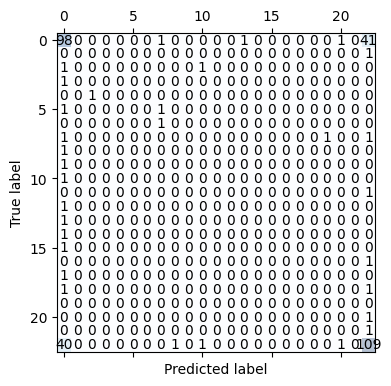

In [157]:
# evaluate model with test set
model_evaluate()

In [113]:
gbtree.predict([[prod_code_map.get("MKV"),prod_id_map.get(3166),10,5000,2,2]])[0]
result_mapping

{0: 0.0,
 1: 0.0666666666666666,
 2: 0.0769230769230769,
 3: 0.0833333333333333,
 4: 0.1,
 5: 0.12,
 6: 0.1333333333333333,
 7: 0.1428571428571428,
 8: 0.1666666666666666,
 9: 0.2,
 10: 0.2222222222222222,
 11: 0.2333333333333333,
 12: 0.24,
 13: 0.25,
 14: 0.2608695652173913,
 15: 0.2727272727272727,
 16: 0.3,
 17: 0.32,
 18: 0.3333333333333333,
 19: 0.3396226415094339,
 20: 0.3421052631578947,
 21: 0.3666666666666666,
 22: 0.4,
 23: 0.4411764705882353,
 24: 0.4615384615384615,
 25: 0.4666666666666667,
 26: 0.5,
 27: 0.5333333333333333,
 28: 0.5454545454545454,
 29: 0.55,
 30: 0.5666666666666667,
 31: 0.5833333333333334,
 32: 0.5925925925925926,
 33: 0.6,
 34: 0.631578947368421,
 35: 0.6333333333333333,
 36: 0.6363636363636364,
 37: 0.64,
 38: 0.65,
 39: 0.6666666666666666,
 40: 0.6875,
 41: 0.7,
 42: 0.7222222222222222,
 43: 0.7333333333333333,
 44: 0.75,
 45: 0.7666666666666667,
 46: 0.7894736842105263,
 47: 0.8,
 48: 0.8266666666666667,
 49: 0.8333333333333334,
 50: 0.8571428571428

c:\Users\Kanis\goodaly\packages\backend\venv\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


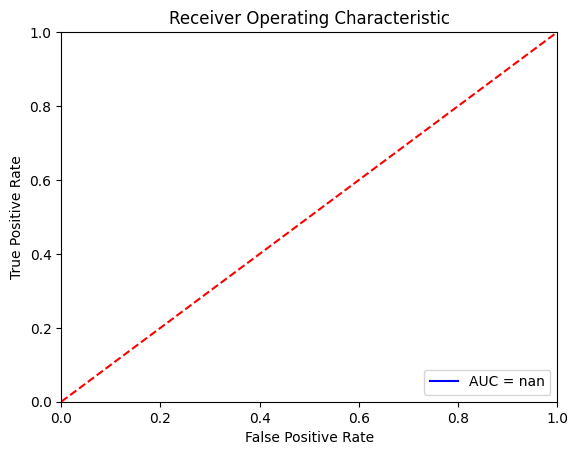

In [33]:
#PLot AUC-curve
import sklearn.metrics as metrics
y_pred = gbtree.predict_proba(test)
fpr, tpr, threshold = metrics.roc_curve(labels_test, y_pred[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
#PLot PR-curve
from sklearn.metrics import precision_recall_curve
y_pred = gbtree.predict_proba(test)
precision, recall, thresholds = precision_recall_curve(labels_test, y_pred[:,1])
 
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

ValueError: multiclass format is not supported

This was an imbalanced dataset where the positive cases were much lesser than the negative. Hence for the positive cases, the LightGBM model gets ~50% of the positive classification correct. There are alot of false negatives & positives.

Let's look at the LightGBM model global importance features, we'll contrast with LIME local importance later.

In [ ]:
# Feature importance
from lightgbm import plot_importance
plot_importance(gbtree)

From a global importance level, it seems the top 3 features are Age, Balance & No. of products.

Now, let's use LIME!!

In [ ]:
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(train.values ,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, kernel_width=3)

Lime tabular needs a predict function

In [ ]:
predict_fn = lambda x: gbtree.predict_proba(x).astype(float)

In [ ]:
#Choose a local instance
chosen = test.iloc[111]
print(chosen)

In [ ]:
print('True class: %s' % class_names[labels_test[111]])

In [ ]:
exp = explainer.explain_instance(chosen, predict_fn,num_features=5)
exp.show_in_notebook(show_all=False)

LIME predicts for this local instance, the 2 features that contribute to the classification is Age and IsActiveMember, rather than the 3 global importance features reported by LightGBM. Let's test this out, by modifying the 2 features that LIME chose 

In [ ]:
chosen['Age'] = 40
chosen['IsActiveMember'] = 0
print(chosen)

In [ ]:
exp = explainer.explain_instance(chosen, predict_fn,num_features=5)
exp.show_in_notebook(show_all=False)

Predicted class probabilities have now changed!
